In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
from datetime import datetime

import json

In [2]:
sns.set_context("notebook")
sns.set_style("dark")
# Determines if Defender/Attacker balance graphs should be ploted by matchup and map or by map only
graphs_by_matchup = False

In [3]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

In [4]:
len(old_raw_data["data"])

223549

## Loading raw data from analytics system

In [5]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [6]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

In [7]:
damage_df.head()

,value,i,t,ips,tps,il,tl,if,tf,ic,tc,Type,match_ts,i-faction-class,t-faction-class,ic_x,ic_y,tc_x,tc_y
0,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4756.736 Y=-11375.842 Z=-338.260,X=6564.843 Y=-13317.048 Z=287.102,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4756.736,-11375.842,6564.843,-13317.048
1,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4761.684 Y=-11146.692 Z=-361.951,X=6216.694 Y=-13053.242 Z=232.571,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4761.684,-11146.692,6216.694,-13053.242
2,15.000000,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4618.393 Y=-10947.164 Z=-392.781,X=5943.171 Y=-12736.564 Z=107.742,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4618.393,-10947.164,5943.171,-12736.564
3,20.742249,CH_2147298354-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147451513-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,MelS,MelS,LSM,CSM,X=4611.332 Y=-10937.122 Z=-394.447,X=5636.104 Y=-11770.576 Z=-218.947,Damage,2023-09-05T14-21-47.813736,LSM-MelS,CSM-MelS,4611.332,-10937.122,5636.104,-11770.576
4,30.000000,CH_2147298023-2023-09-05T14-21-47.813736,CH_2147299959-2023-09-05T14-21-47.813736,PS_2147480996-2023-09-05T14-21-47.813736,PS_2147476510-2023-09-05T14-21-47.813736,TacS,MelS,LSM,CSM,X=4294.929 Y=-11244.208 Z=-363.980,X=5578.625 Y=-11682.660 Z=-242.010,Damage,2023-09-05T14-21-47.813736,LSM-TacS,CSM-MelS,4294.929,-11244.208,5578.625,-11682.660


In [8]:
# damage_df["value"] = pd.to_numeric(damage_df["value"])
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first')
)
damage_per_pawn.head()

,damage_per_life,loadout
i,,
CH_2145795998-2023-09-09T19-47-40.033082,195.000000,LSM-SupS
CH_2145797202-2023-09-09T19-47-40.033082,183.429123,LSM-TacS
CH_2145797577-2023-09-09T19-47-40.033082,110.000000,CSM-HboS
CH_2145800736-2023-09-09T19-47-40.033082,460.000000,CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082,635.000000,LSM-MelS


In [9]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,958.116260,852.608980
CSM-HboS,853.411691,937.475009
CSM-JpaS,440.890554,497.602664
CSM-JpaVA,911.053353,861.601987
CSM-MelS,424.629327,426.921999
CSM-MelV,588.443820,556.289769
CSM-PcaS,827.009475,982.002681
CSM-SupS,414.061059,494.016741
CSM-TacS,527.970164,618.042296


In [10]:
# On subplots
# fig, axes = plt.subplots(2, 2)
# Returns the future plotted figure and the subplot grid
# They can be used in at least two ways :
#     axes[i, j].plot(data)
#     .boxplot(by = "data", ax=axes[i, j])

# Getting sub dataframes (those can be chained)
# damage_per_pawn[damage_per_pawn["loadout"] == "CSM-AucV"]
# damage_per_pawn[damage_per_pawn["loadout"].isin(["CSM-AucV", "LSM-AucV"])]
# damage_per_pawn[damage_per_pawn["loadout"].str.startswith("CSM")]
# damage_per_pawn[damage_per_pawn["loadout"].str.contains("S")]
# To get what doesn't satisfy the condition, add a ~
# damage_per_pawn[~damage_per_pawn["loadout"] == "CSM-AucV"]

In [11]:
factions = [
    "LSM", 
    "CSM"
]
classes = [
    "Auc",
    "Hbo",
    "Jpa",
    "Mel",
    "Pca",
    "Sup",
    "Tac"
]

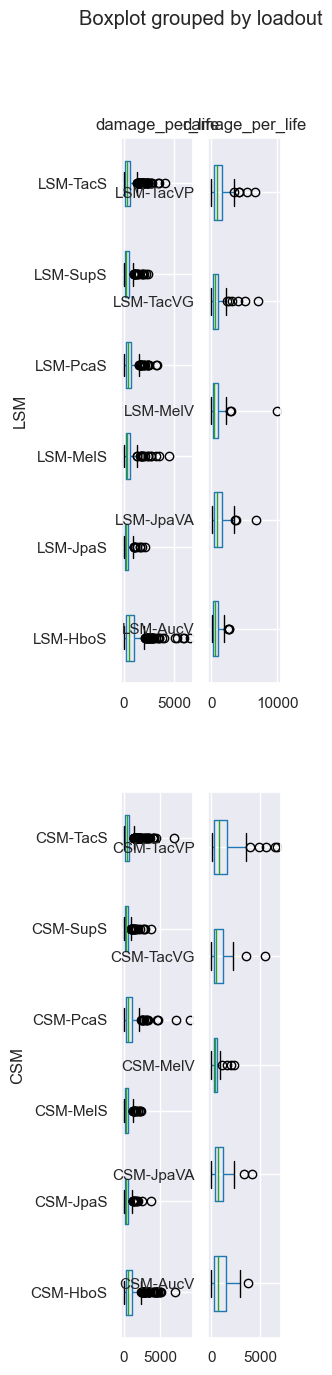

In [12]:
fig, axes = plt.subplots(len(factions), 2, figsize=(len(factions), 16))
base = damage_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    standard.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,0])
    veteran.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    
# axs[1, 1].boxplot(damage_per_pawn, vert=False)
# damage_per_pawn.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[1,1])
# sns.violinplot(damage_per_pawn, x="damage_per_life", y="loadout")

## Analyzing XP (per pawn, per class and action)

In [13]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])
xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
0,CH_2147298023-2023-09-05T14-21-47.813736,-15.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4138.131 Y=-11216.999 Z=-355.835,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4138.131,-11216.999
1,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4376.996 Y=-11282.090 Z=-354.907,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4376.996,-11282.090
2,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.307 Y=-11435.213 Z=-337.219,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.307,-11435.213
3,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.654 Y=-11436.802 Z=-337.044,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.654,-11436.802
4,CH_2147298354-2023-09-05T14-21-47.813736,50.0,PS_2147451513-2023-09-05T14-21-47.813736,LSM,MelS,X=4923.494 Y=-11255.877 Z=-338.951,Assist,XP,2023-09-05T14-21-47.813736,LSM-MelS,4923.494,-11255.877


In [14]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn_and_action.head()

xp_per_life   loadout
t                                        action                               
CH_2145796526-2023-09-09T19-47-40.033082 Assist                 50.0  CSM-TacS
CH_2145800736-2023-09-09T19-47-40.033082 Assist                 50.0  CSM-MelV
                                         Enemy down            100.0  CSM-MelV
                                         Enemy finished         50.0  CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082 Assist                 50.0  LSM-MelS

In [15]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn.head()

,xp_per_life,loadout
t,,
CH_2145796526-2023-09-09T19-47-40.033082,50.0,CSM-TacS
CH_2145800736-2023-09-09T19-47-40.033082,200.0,CSM-MelV
CH_2145802590-2023-09-09T19-47-40.033082,900.0,LSM-MelS
CH_2145802992-2023-09-09T19-47-40.033082,950.0,LSM-SupS
CH_2145803389-2023-09-09T19-47-40.033082,800.0,LSM-MelS


In [16]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class_and_action.head()

mean_xp_per_life  std_xp_per_life
loadout  action                                            
CSM-AucV Ally down             -500.000000              NaN
         Ally finished         -100.000000              NaN
         Ally revived           150.000000         0.000000
         Assist                  95.833333        50.897738
         Capture stopped        600.000000       427.617987

In [17]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,560.350000,850.027558
CSM-HboS,448.749585,664.233812
CSM-JpaS,539.661538,628.801525
CSM-JpaVA,824.711111,970.093801
CSM-MelS,513.251282,597.122778
CSM-MelV,786.962963,821.834603
CSM-PcaS,207.153527,508.355680
CSM-SupS,414.745614,645.832077
CSM-TacS,519.752823,760.350019


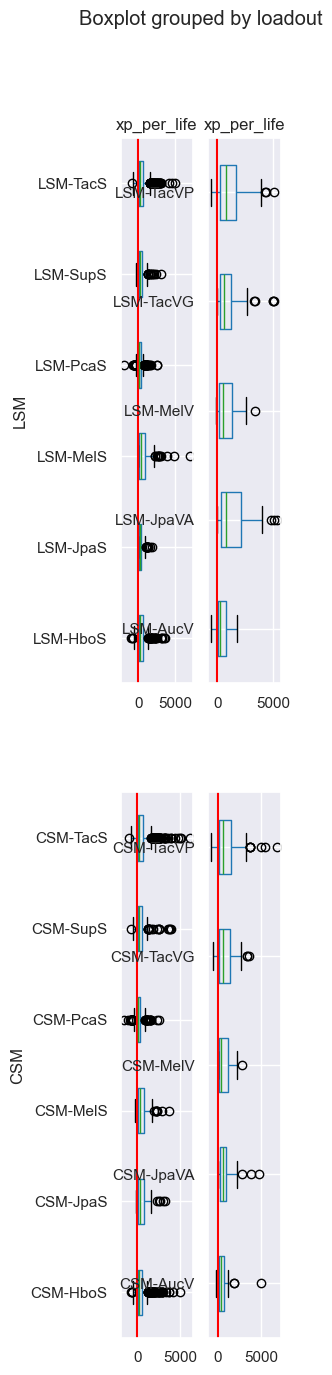

In [18]:
fig, axes = plt.subplots(len(factions), 2, figsize=(len(factions), 16))
base = xp_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    standard.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,0])
    veteran.sort_values(by='loadout').boxplot(by="loadout", vert=False, ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    axes[i,0].axvline(x=0, color='red')
    axes[i,1].axvline(x=0, color='red')

# xp_per_pawn.sort_values(by='loadout').boxplot(by='loadout', vert=False)

# plt.axvline(x=0, color='red')
# plt.show()



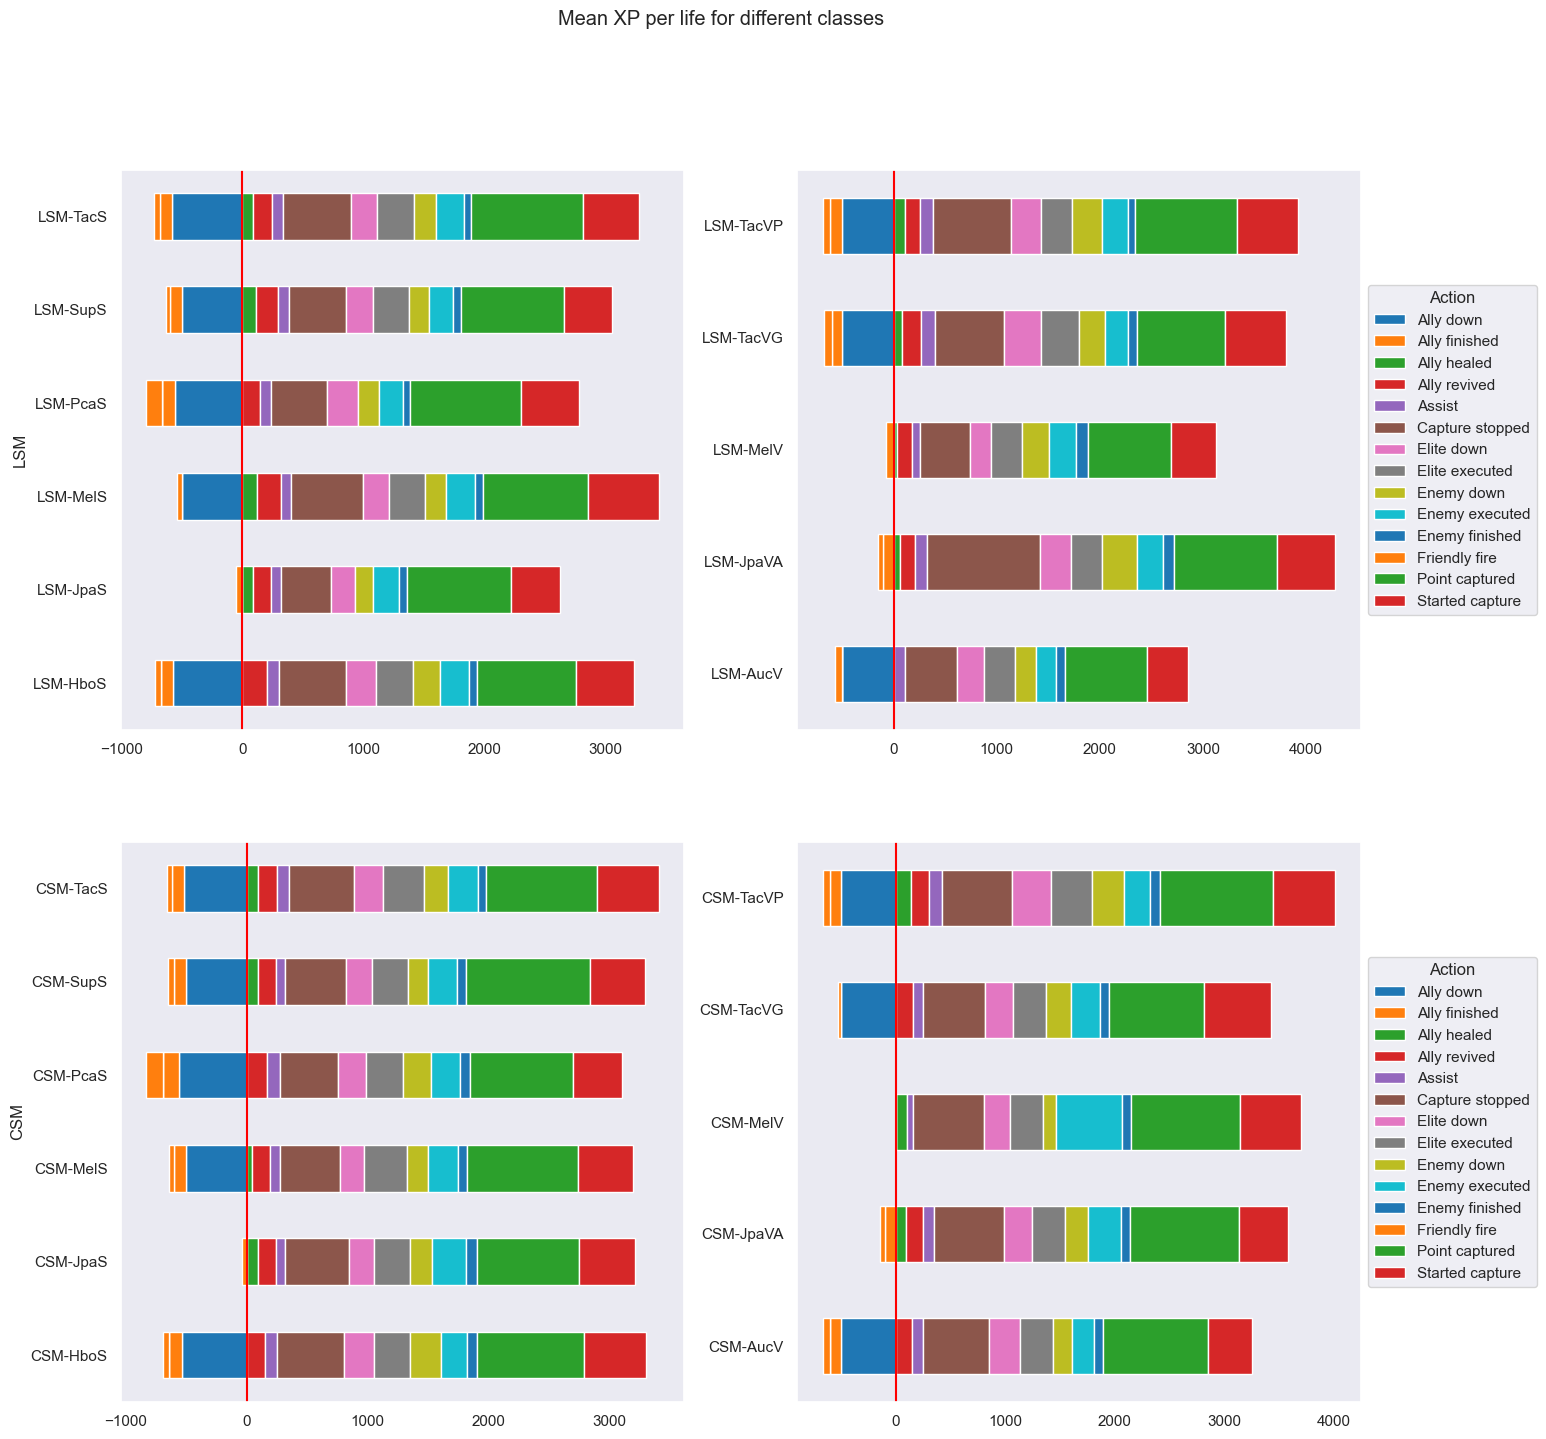

In [19]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index='loadout', columns='action',
                                                                                      values='mean_xp_per_life')

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

fig, axes = plt.subplots(len(factions), 2, figsize=(len(factions)*8, 16))
fig.suptitle("Mean XP per life for different classes")
base = pivot_xp_per_life_for_class_and_action

for i in range (0, len(factions)):
    # Get faction
    standard = base[base.index.str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard.index.str.contains(classes[j]+"V")]
        veteran = veteran[~veteran.index.str.contains(classes[j]+"S")]
    standard.plot(kind='barh', ax=axes[i,0], stacked=True, style=custom_colors)
    veteran.plot(kind='barh', ax=axes[i,1], stacked=True, style=custom_colors)

    # Sort titles and labels and stuff
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")
    axes[i,0].axvline(x=0, color='red')
    axes[i,1].axvline(x=0, color='red')
    axes[i,0].get_legend().remove()
    axes[i,1].legend(title='Action', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a rotated stacked barplot with the custom color palette
# ax = pivot_xp_per_life_for_class_and_action.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors)

# Customize the plot
# plt.title('Mean XP per life for different classes')
# plt.xlabel('Mean XP per life')
# plt.ylabel('Loadout')
# plt.legend(title='Action')

# plt.axvline(x=0, color='red')

# Show the plot
# plt.show()

## Analyzing KD ratios

In [20]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
5,CH_2147298023-2023-09-05T14-21-47.813736,100.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=5075.189 Y=-11603.107 Z=-239.720,Enemy down,XP,2023-09-05T14-21-47.813736,LSM-TacS,5075.189,-11603.107
7,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4580.340 Y=-6189.420 Z=574.910,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4580.340,-6189.420
11,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4736.840 Y=-3964.140 Z=561.360,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4736.840,-3964.140
16,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3769.990 Y=-4582.180 Z=555.990,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3769.990,-4582.180
18,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3640.960 Y=-3521.410 Z=559.720,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3640.960,-3521.410


In [21]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first')
)
kills_per_pawn.head()

,kill_count,loadout
t,,
CH_2145800736-2023-09-09T19-47-40.033082,1,CSM-MelV
CH_2145802992-2023-09-09T19-47-40.033082,1,LSM-SupS
CH_2145803813-2023-09-09T19-47-40.033082,1,LSM-HboS
CH_2145805677-2023-09-09T19-47-40.033082,2,CSM-JpaS
CH_2145806625-2023-09-09T19-47-40.033082,1,CSM-TacVG


In [22]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,1.750000,1.265643
CSM-HboS,2.528767,2.413872
CSM-JpaS,1.863636,1.311328
CSM-JpaVA,2.160000,1.598958
CSM-MelS,1.739130,1.127767
CSM-MelV,1.250000,0.621582
CSM-PcaS,2.303030,1.949513
CSM-SupS,1.655172,1.301409
CSM-TacS,1.983452,1.660015


In [23]:
# kills_per_pawn.sort_values(by='loadout').boxplot(by="loadout", vert=False, bootstrap=1000)
# sns.violinplot(kills_per_pawn, x="kill_count", y="loadout")

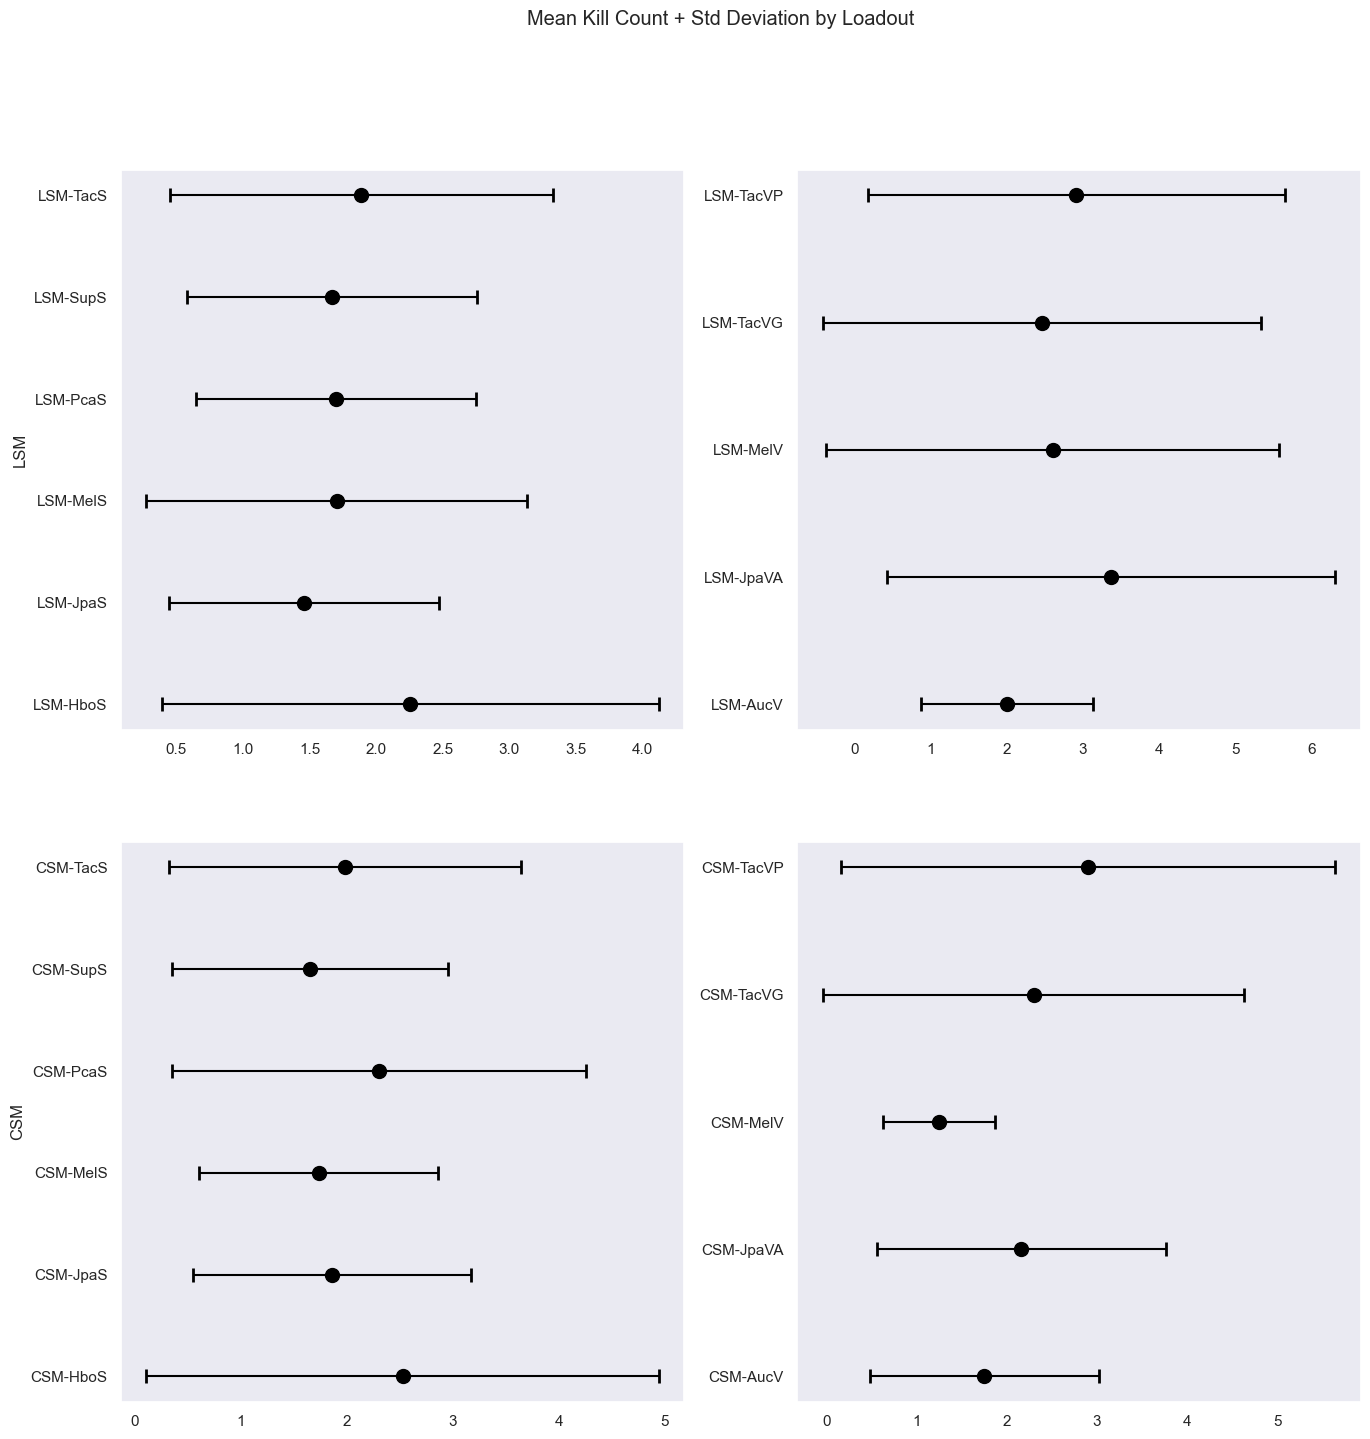

In [24]:
fig, axes = plt.subplots(len(factions), 2, figsize=(len(factions)*8, 16))
fig.suptitle("Mean Kill Count + Std Deviation by Loadout")
base = kills_per_pawn

for i in range (0, len(factions)):
    # Get faction
    standard = base[base["loadout"].str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard["loadout"].str.contains(classes[j]+"V")]
        veteran = veteran[~veteran["loadout"].str.contains(classes[j]+"S")]
    grouped = standard.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()
    axes[i,0].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
    for j, (mean_val, std_val) in enumerate(zip(means, stds)):
        axes[i,0].errorbar(mean_val, j, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    grouped = veteran.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()
    axes[i,1].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
    for j, (mean_val, std_val) in enumerate(zip(means, stds)):
        axes[i,1].errorbar(mean_val, j, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')


    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")

In [25]:
# Calculate mean and standard deviation
# grouped = kills_per_pawn.groupby('loadout')['kill_count']
# means = grouped.mean()
# stds = grouped.std()

# Create a horizontal scatter plot for means
# plt.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

# Create vertical bars for standard deviation
# for i, (mean_val, std_val) in enumerate(zip(means, stds)):
#    plt.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

# Set labels and title
# plt.xlabel('Value')
# plt.ylabel('Loadout')
# plt.title('Mean Kill count ± Std Deviation by Loadout')

# plt.show()

## Analyzing class frequencies

In [26]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [27]:
class_spawns = spawn_df["t-faction-class"].value_counts()

In [28]:
class_spawns.index

Index(['CSM-TacS', 'LSM-TacS', 'CSM-HboS', 'LSM-HboS', 'LSM-MelS', 'CSM-SupS',
       'LSM-PcaS', 'LSM-SupS', 'CSM-PcaS', 'CSM-MelS', 'LSM-JpaS', 'CSM-JpaS',
       'LSM-TacVP', 'CSM-TacVP', 'LSM-JpaVA', 'CSM-TacVG', 'LSM-TacVG',
       'LSM-AucV', 'CSM-AucV', 'CSM-JpaVA', 'LSM-MelV', 'CSM-MelV'],
      dtype='object', name='t-faction-class')

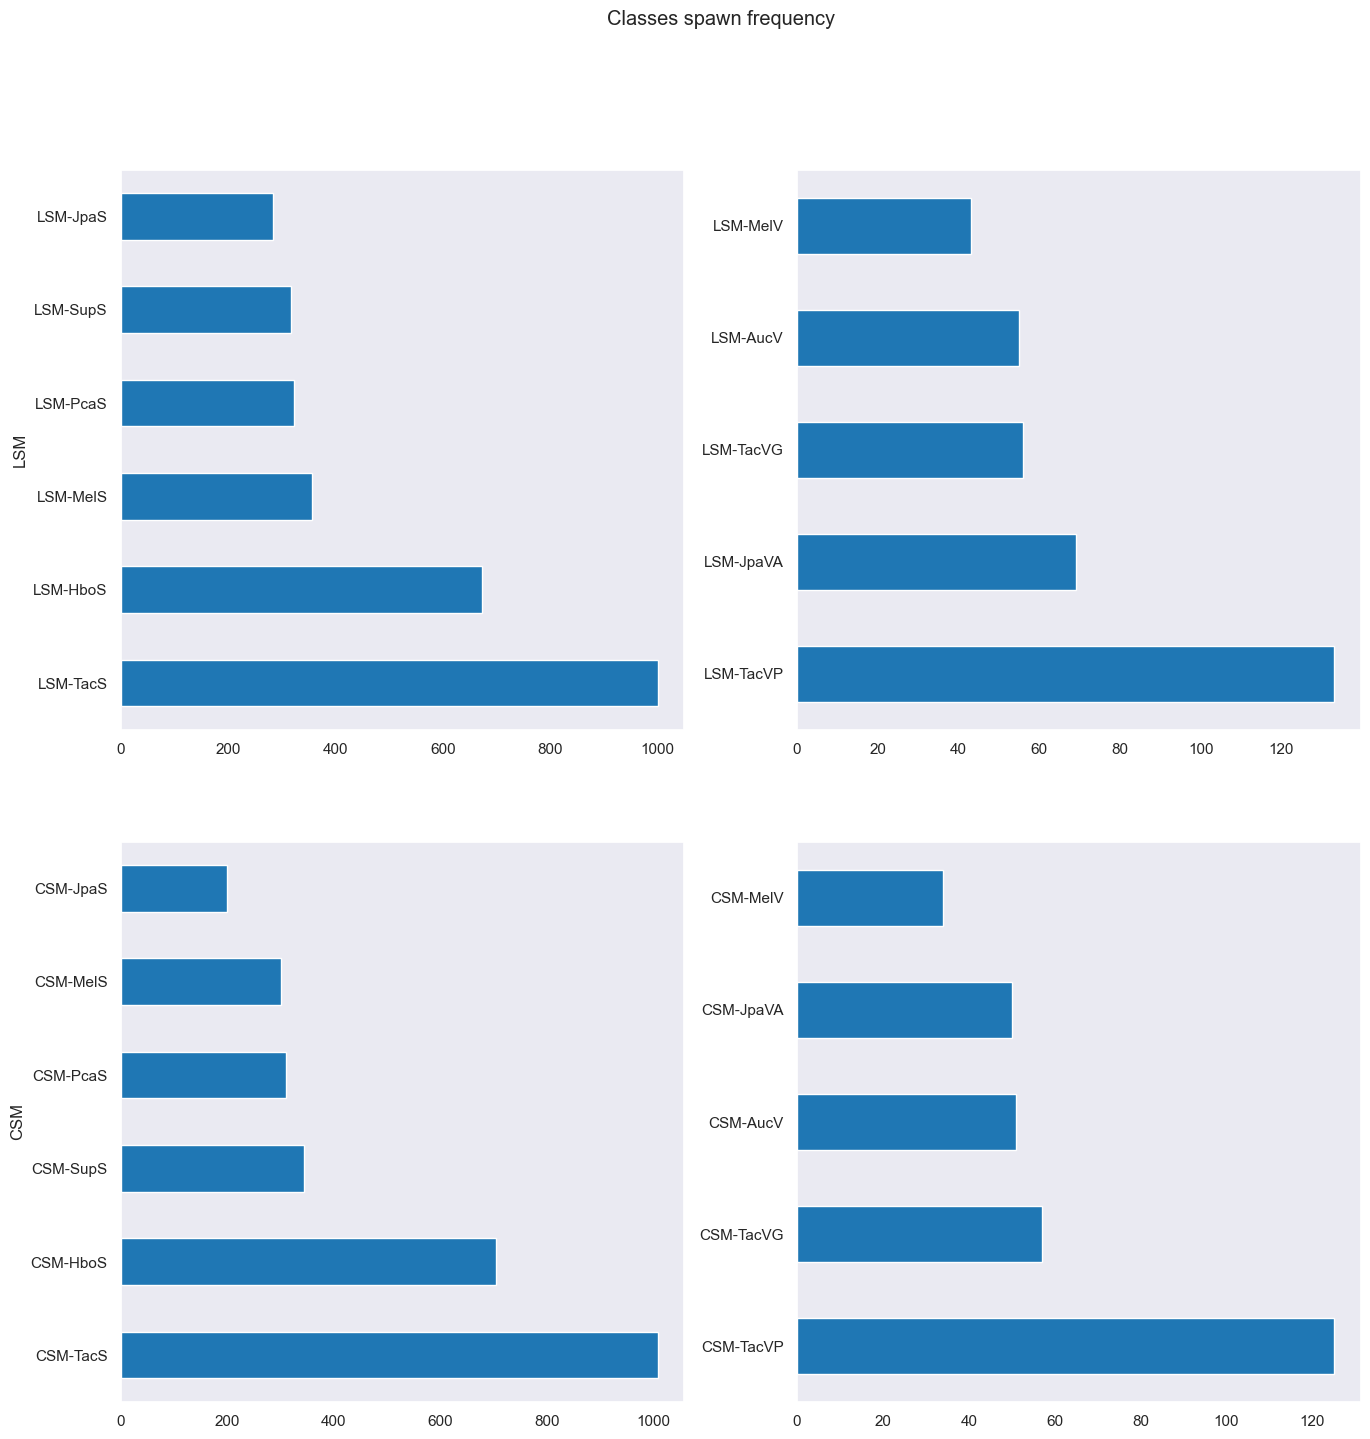

In [29]:
fig, axes = plt.subplots(len(factions), 2, figsize=(len(factions)*8, 16))
fig.suptitle("Classes spawn frequency")
base = class_spawns

for i in range (0, len(factions)):
    # Get faction
    standard = base[base.index.str.startswith(factions[i])]
    veteran = standard

    # Get Standard or Veteran classes
    for j in range (0, len(classes)):
        standard = standard[~standard.index.str.contains(classes[j]+"V")]
        veteran = veteran[~veteran.index.str.contains(classes[j]+"S")]
    standard.plot(kind='barh', ax=axes[i,0])
    veteran.plot(kind='barh', ax=axes[i,1])

    # Sort titles and labels
    if (i != 0):
        axes[i,0].set_title("")
        axes[i,1].set_title("")
    axes[i,0].set_ylabel(factions[i])
    axes[i,1].set_ylabel("")

In [30]:
class_spawns.head()

t-faction-class
CSM-TacS    1008
LSM-TacS    1000
CSM-HboS     704
LSM-HboS     673
LSM-MelS     356
Name: count, dtype: int64

In [31]:
# class_spawns.plot.barh(title="Classes spawn frequency")

## Heatmaps

### Damage dealers

In [32]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

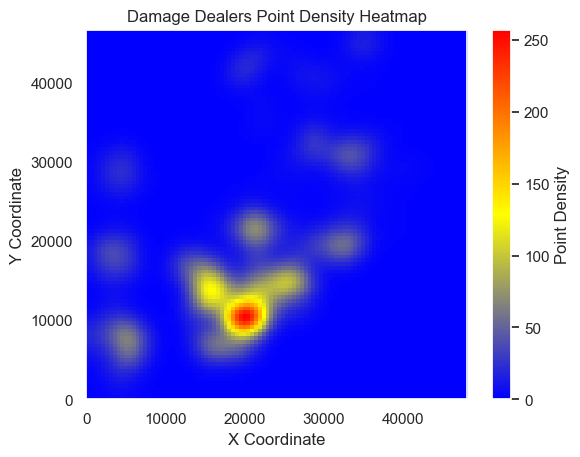

In [33]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()

## Prefered Maps and Missions

### Maps

In [34]:
maps = {}
pair = True
for e in old_raw_data["data"]:
    if ("map" in e.keys()):
        if (pair):
            if (e["map"] in maps.keys()):
                maps[e["map"]] = maps[e["map"]] + 1
            else:
                maps[e["map"]] = 1
            pair = False
        else:
            pair = True
maps

{'CycladonComplex': 25,
 'RailgateRavine': 12,
 'Olipsis': 10,
 'ZedekSmall': 8,
 'MaccragesFury': 10}

Text(0.5, 1.0, 'Number of times played (Map)')

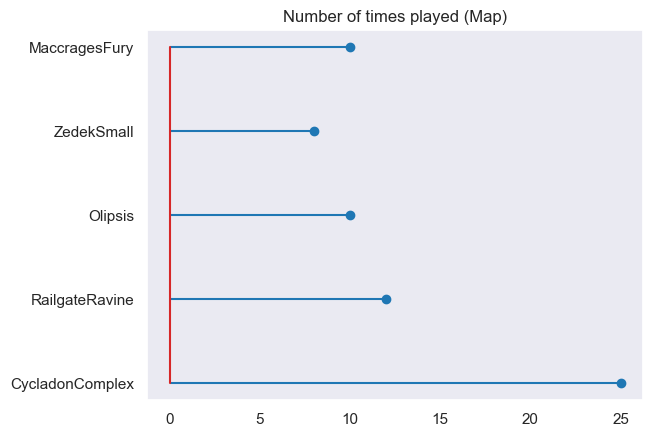

In [35]:
plt.stem(maps.keys(), maps.values(), orientation='horizontal')
plt.title("Number of times played (Map)")

### Missions

In [36]:
missions = {}
pair = True
for e in old_raw_data["data"]:
    if (("mission" in e.keys()) and ("map" in e.keys())):
        if (pair):
            if (e["map"] in missions.keys()):
                if (e["mission"] in missions[e["map"]].keys()):
                    missions[e["map"]][e["mission"]] = missions[e["map"]][e["mission"]] + 1
                else:
                    missions[e["map"]][e["mission"]] = 1
            else:
                missions[e["map"]] = {}
                missions[e["map"]][e["mission"]] = 1
            pair = False
        else:
            pair = True
missions

{'CycladonComplex': {'B_GM_Supremacy_Cycladon_C': 25},
 'RailgateRavine': {'B_GM_HoldTheLine_Railgate_C': 12},
 'Olipsis': {'B_GM_Supremacy_Olipsis_C': 10},
 'ZedekSmall': {'B_GM_MasterDeepStrike_ZedekSmall_C': 8},
 'MaccragesFury': {'B_GM_MasterBoardingAction_MaccragesFury_C': 10}}

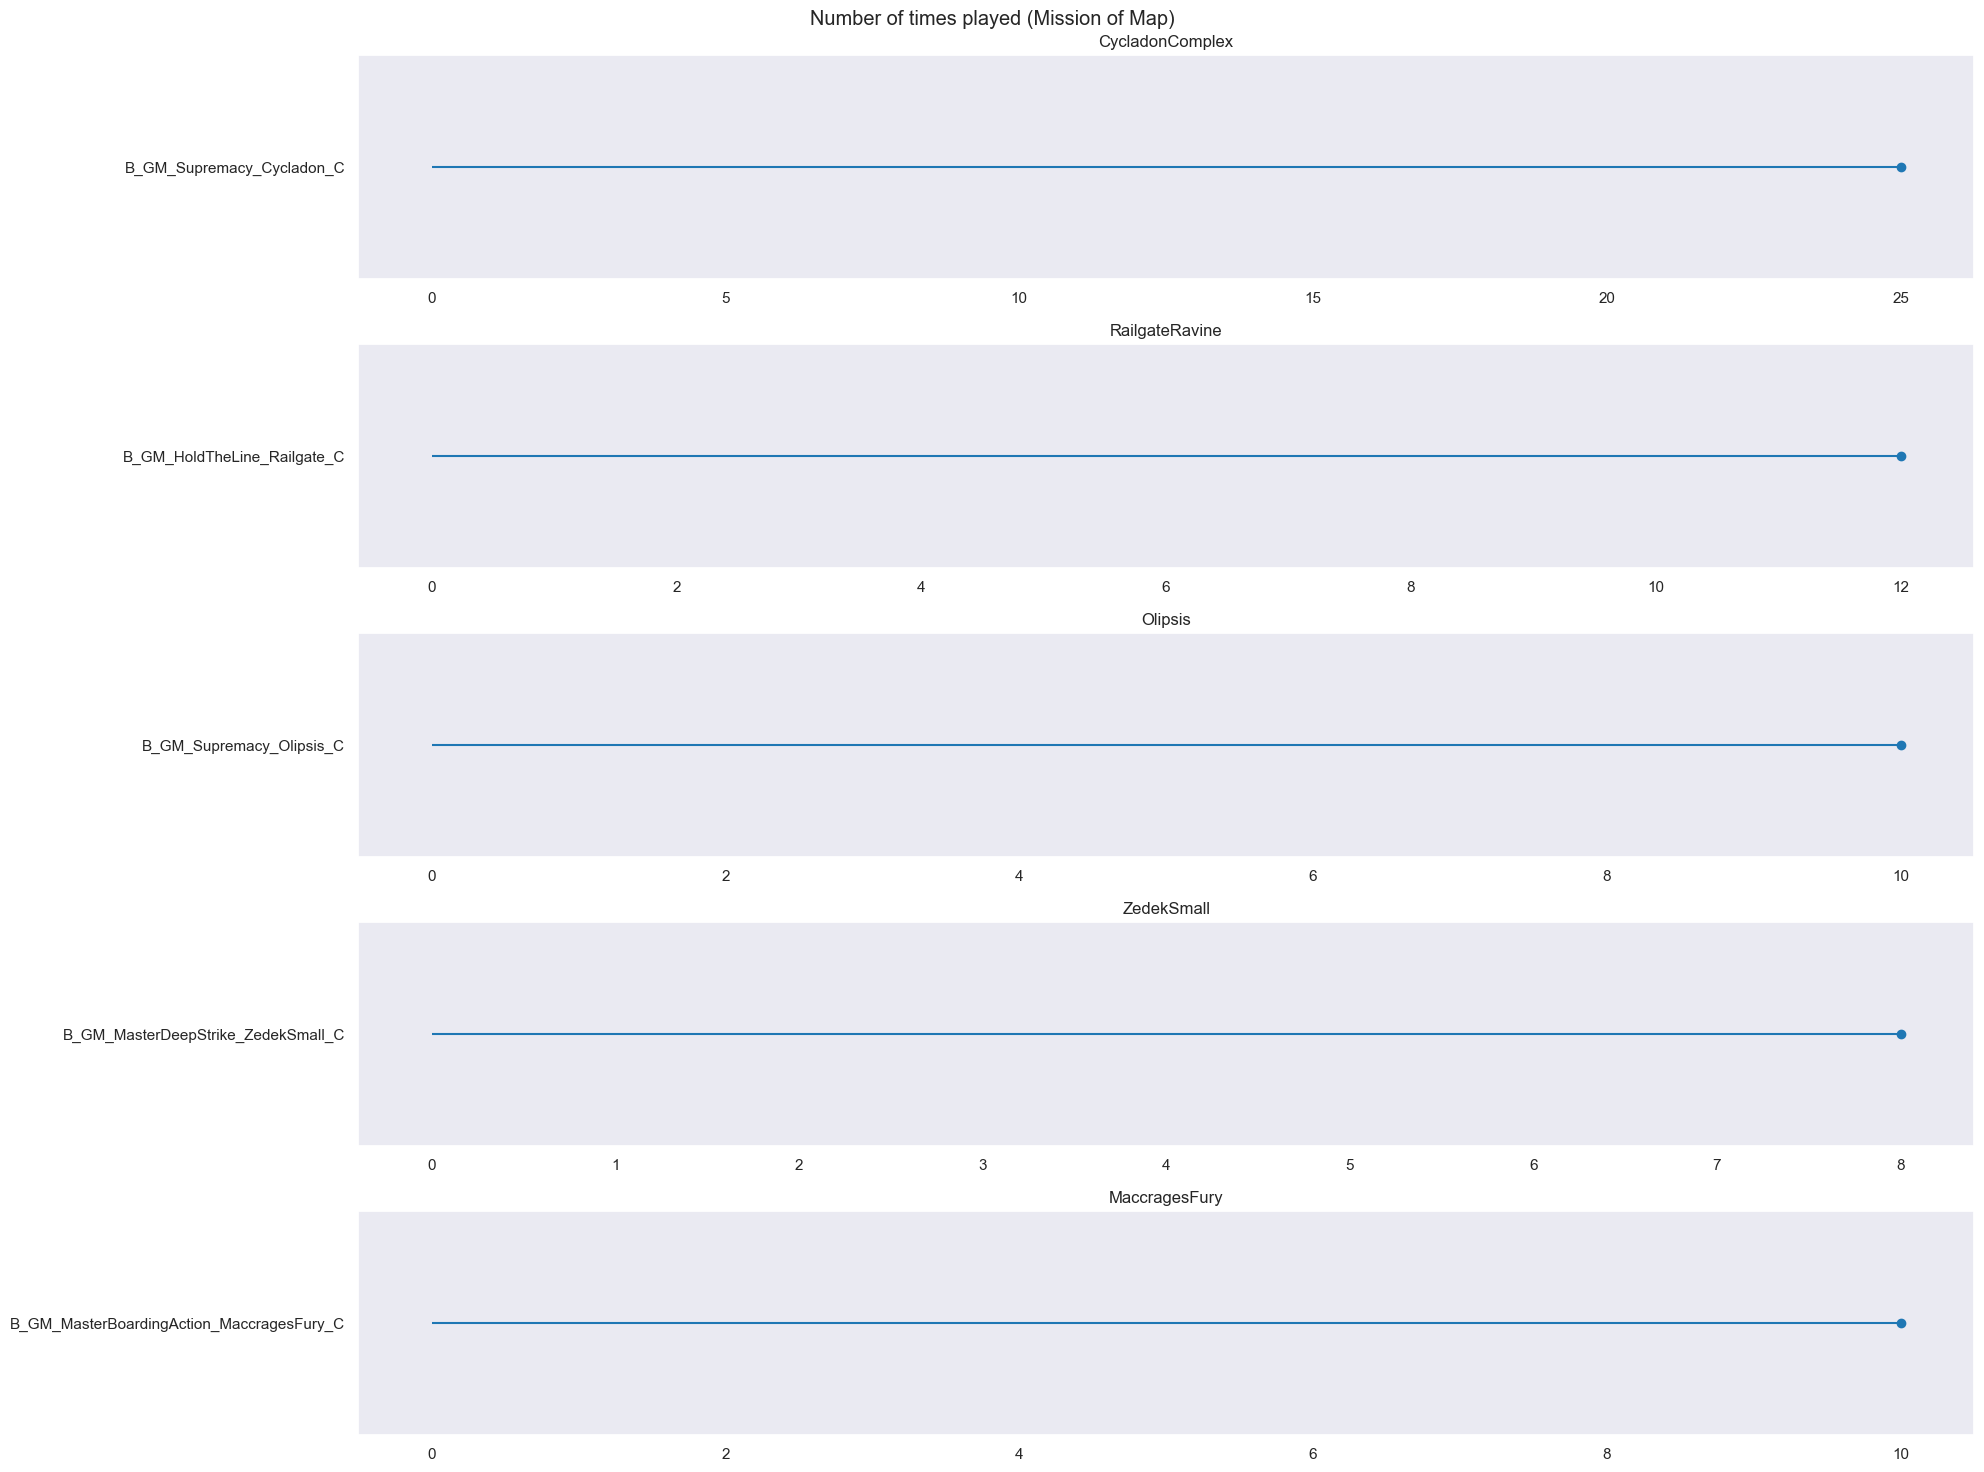

In [37]:
fig, axes = plt.subplots(len(missions), 1, figsize=(len(missions)*4, 15))
fig.suptitle("Number of times played (Mission of Map)")
base = missions

i = 0
for e in (missions.keys()):
    axes[i].stem(missions[e].keys(), missions[e].values(), orientation='horizontal')
    axes[i].set_title(e)
    i = i + 1

fig.tight_layout()

# Defender/Attacker Balance

In [38]:
if use_example:
    with open("example-real-data.json", "rb") as f:
        by_match_old_raw_data = json.load(f)
else:
    # Spliting the data by match instead of merging all the entries in a single list like before
    by_match_old_raw_data = []
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                by_match_old_raw_data.append( [{**el, "match_ts": match_ts} for el in match_data["data"]] )

In [39]:
len(by_match_old_raw_data)

65

In [40]:
by_match_old_raw_data[0][-1]

{'map': 'CycladonComplex',
 'mission': 'B_GM_Supremacy_Cycladon_C',
 't1': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 10000,\r\n\t"maxScore": 10000,\r\n\t"goal": "Attacker",\r\n\t"spawnsLimited": false\r\n}',
 't2': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"ChaosSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 7819,\r\n\t"maxScore": 10000,\r\n\t"goal": "Defender",\r\n\t"spawnsLimited": true\r\n}',
 't3': '',
 't4': '',
 'pa': '',
 'ts': '',
 'winner': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 10000,\r\n\t"maxScore": 10000,\r\n\t"goal": "Attacker",\r\n\t"spawnsLimited": false\r\n}',
 'duration': '1693923949.287',
 'minduration': '600.0',
 'maxduration': '1230.0',
 'Type': 'MatchEnd',
 'match_ts': '2023-09-05T14-21-47.813736'}

In [41]:
# 1) For every mission, get defender winrate (mission y, winrate x) and plot as hbar, vertical red line at 0.5
# 2) For every mission, get "defenders' total xp / attacker total xp" and plot as mean +- std between matches (mission y, ratio x), vertical red line at 1
# 3) For every mission, get "(defenders' kills / defenders' spawns) / (same for attackers)", plot as mean +- std between matches (mission y, ratio x), vertical red line at 1
# 4) For every mission, get match duration, plot as boxplots (mission y, duration x)

## 1) For every mission, get defender winrate (mission y, winrate x) and plot as hbar, vertical red line at 0.5

In [42]:
def split_team_info(str):
    alliance = ""
    goal = ""
    
    # Get usefull elements from team info
    values = str.split("\"")[1::2]
    for i in range (0, len(values)):
        if (values[i] == "factionNames"):
            i = i + 1
            for i in range (i, len(values)):
                if (values[i] != "strength"):
                    alliance += (values[i])
                else:
                    break

        if (values[i] == "goal"):
            i = i + 1
            goal = values[i]
    
    return alliance, goal

In [43]:
# Get missions played to the end
missions = {}
if (graphs_by_matchup):
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
        
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = {}
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], 1])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], 1]]
                else:
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], 0])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], 0]]
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], 1])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], 1]]
                else:
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], 0])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], 0]]

else:
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
        
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = []
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    missions[end_entry["mission"]].append(1)
                else:
                    missions[end_entry["mission"]].append(0)
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    missions[end_entry["mission"]].append(1)
                else:
                    missions[end_entry["mission"]].append(0)

In [44]:
# missions

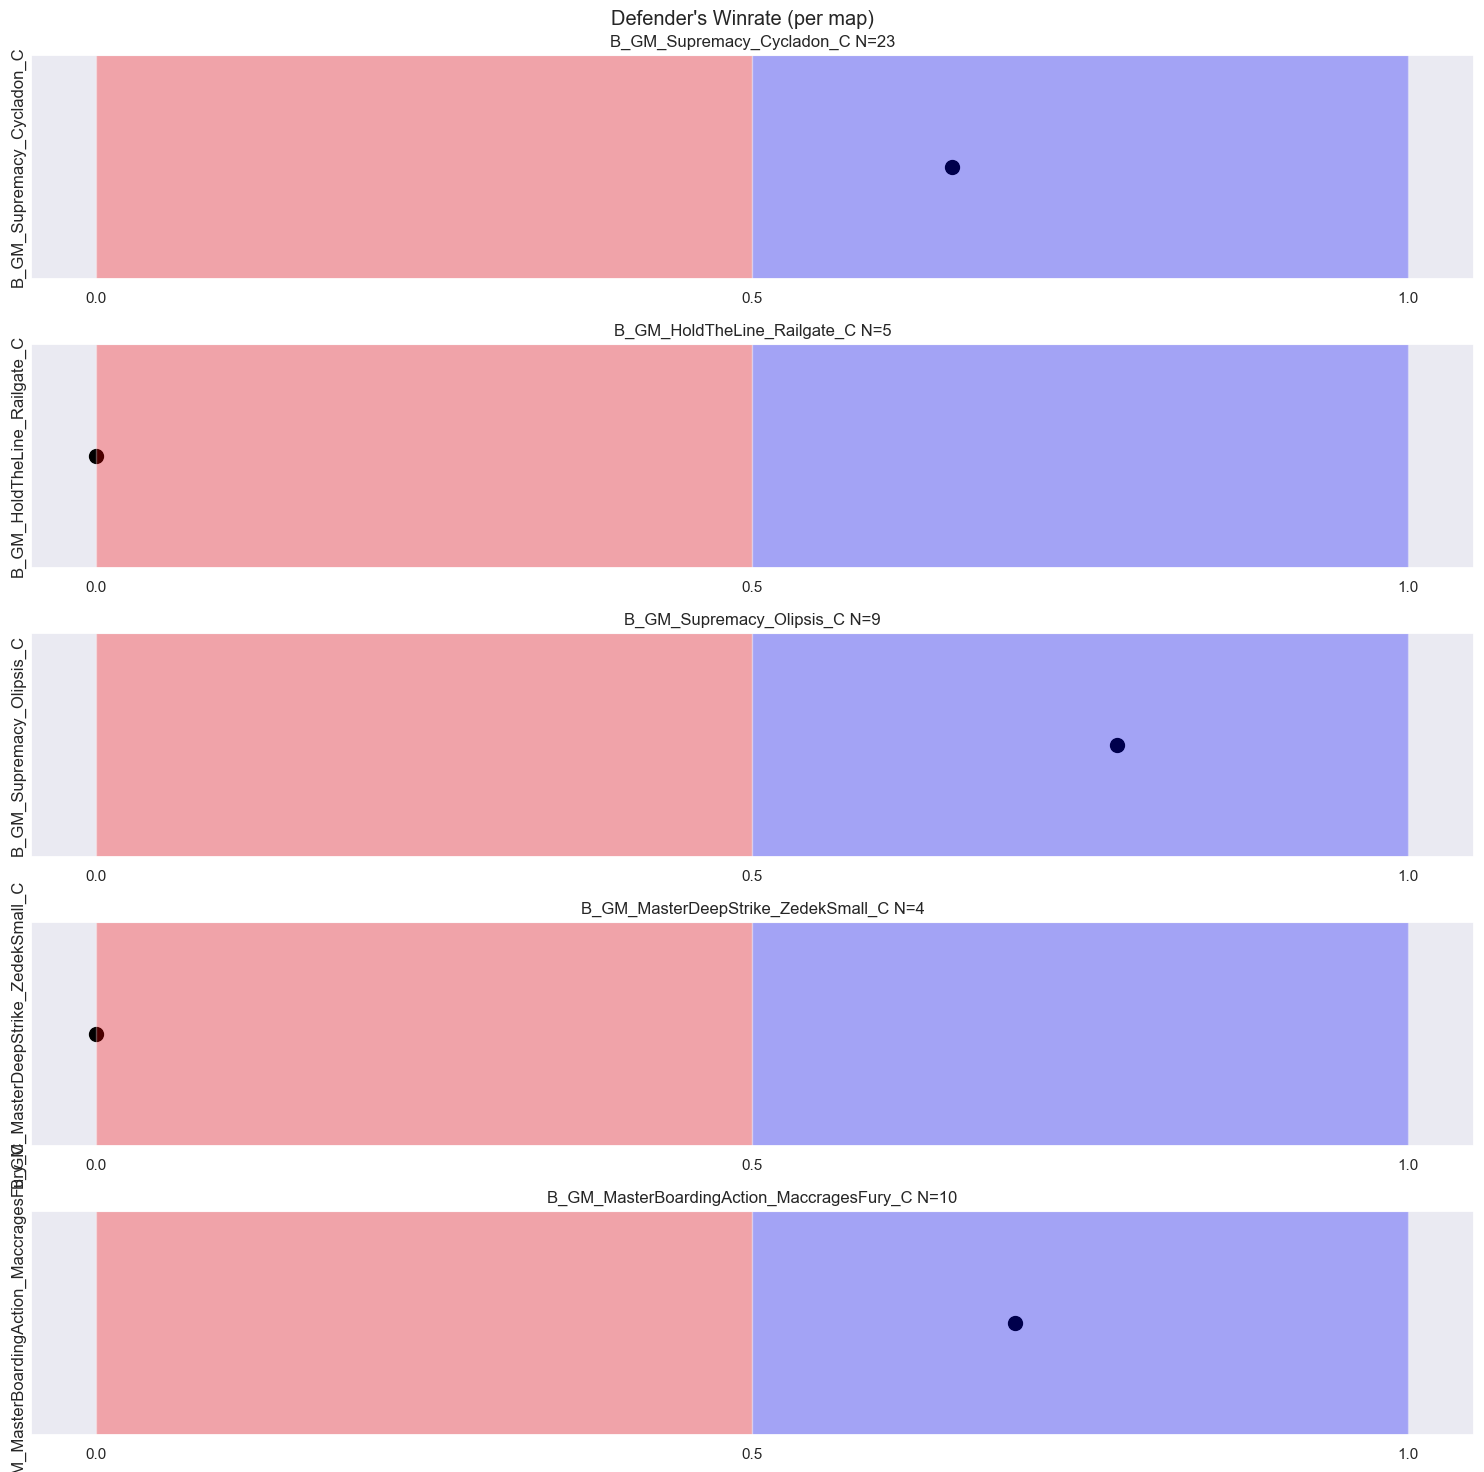

In [45]:
# Plot winrate
if (graphs_by_matchup):
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 4, figsize=(len(keys)*4, 20))
    fig.suptitle("Defender's Winrate (per map, per alliance)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        for j, subkey in enumerate(mission.keys()):
            df = pd.DataFrame(data=mission[subkey]).groupby(0).agg(
                faction=(0, 'first'),
                winrate=(1, 'mean')
            )
            df.plot(1, 0, kind='scatter', s=100, color='black', ax=axes[i,j], xticks=[0, 0.5, 1])
            axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
            axes[i,j].set_title(subkey)
            axes[i,j].axvspan(0.0, 0.5, facecolor='r', alpha=0.3)
            axes[i,j].axvspan(0.5, 1.0, facecolor='b', alpha=0.3)
            axes[i,j].set_ylabel("")
        axes[i,0].set_ylabel(key)
    
    fig.tight_layout()

else:
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 1, figsize=(15, 15))
    fig.suptitle("Defender's Winrate (per map)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        mean = [np.mean(mission)]
        axes[i].scatter(mean, 0, s=100, color="black")
        axes[i].set_xticks([0, 0.5, 1])
        axes[i].set_yticks([])
        axes[i].set_title(key + " N=" + str(len(mission)))
        axes[i].axvspan(0.0, 0.5, facecolor='r', alpha=0.3)
        axes[i].axvspan(0.5, 1.0, facecolor='b', alpha=0.3)
        axes[i].set_ylabel(key)
    
    fig.tight_layout()

## 2) For every mission, get "defenders' total xp / attacker total xp" and plot as mean +- std between matches (mission y, ratio x), vertical red line at 1

In [46]:
for i in range(0, 10):
    print(by_match_old_raw_data[i][-2])

{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T14-21-47.813736'}
{'faction': 'LSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T16-05-20.750330'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T18-16-00.784233'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T18-58-40.952859'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-21-46.891769'}
{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-34-43.514643'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T19-57-18.815362'}
{'faction': 'LSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-05T20-20-31.494811'}
{'faction': 'CSM', 'result': 'lost', 'Type': 'WonLost', 'match_ts': '2023-09-05T21-35-40.741946'}
{'faction': 'CSM', 'result': 'won', 'Type': 'WonLost', 'match_ts': '2023-09-06T21-31-15.962131'}


In [47]:
def get_side_xp(match, faction):
    sum = 0
    for e in match:
        if ((e["Type"] == "XP") and (e["tf"] == faction)):
            sum += int(e["value"])
    return sum

In [48]:
missions = {}
if (graphs_by_matchup):
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate side XP
            resultA = match[-2]
            resultB = match[-3]
            xpA = get_side_xp(match, resultA["faction"])
            xpB = get_side_xp(match, resultB["faction"])
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = {}
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    if (resultA["result"] == "won"):
                        ratio = xpA/xpB
                    else:
                        ratio = xpB/xpA
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], ratio])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], ratio]]
                else:
                    if (resultA["result"] == "won"):
                        ratio = xpB/xpA
                    else:
                        ratio = xpA/xpB
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], ratio])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], ratio]]
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    if (resultA["result"] == "won"):
                        ratio = xpA/xpB
                    else:
                        ratio = xpB/xpA
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], ratio])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], ratio]]
                else:
                    if (resultA["result"] == "won"):
                        ratio = xpB/xpA
                    else:
                        ratio = xpA/xpB
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], ratio])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], ratio]]

else:
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate side XP
            resultA = match[-2]
            resultB = match[-3]
            xpA = get_side_xp(match, resultA["faction"])
            xpB = get_side_xp(match, resultB["faction"])
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = []
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    if (resultA["result"] == "won"):
                        ratio = xpA/xpB
                    else:
                        ratio = xpB/xpA
                    missions[end_entry["mission"]].append(ratio)
                else:
                    if (resultA["result"] == "won"):
                        ratio = xpB/xpA
                    else:
                        ratio = xpA/xpB
                    missions[end_entry["mission"]].append(ratio)
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    if (resultA["result"] == "won"):
                        ratio = xpA/xpB
                    else:
                        ratio = xpB/xpA
                    missions[end_entry["mission"]].append(ratio)
                else:
                    if (resultA["result"] == "won"):
                        ratio = xpB/xpA
                    else:
                        ratio = xpA/xpB
                    missions[end_entry["mission"]].append(ratio)

In [49]:
# missions

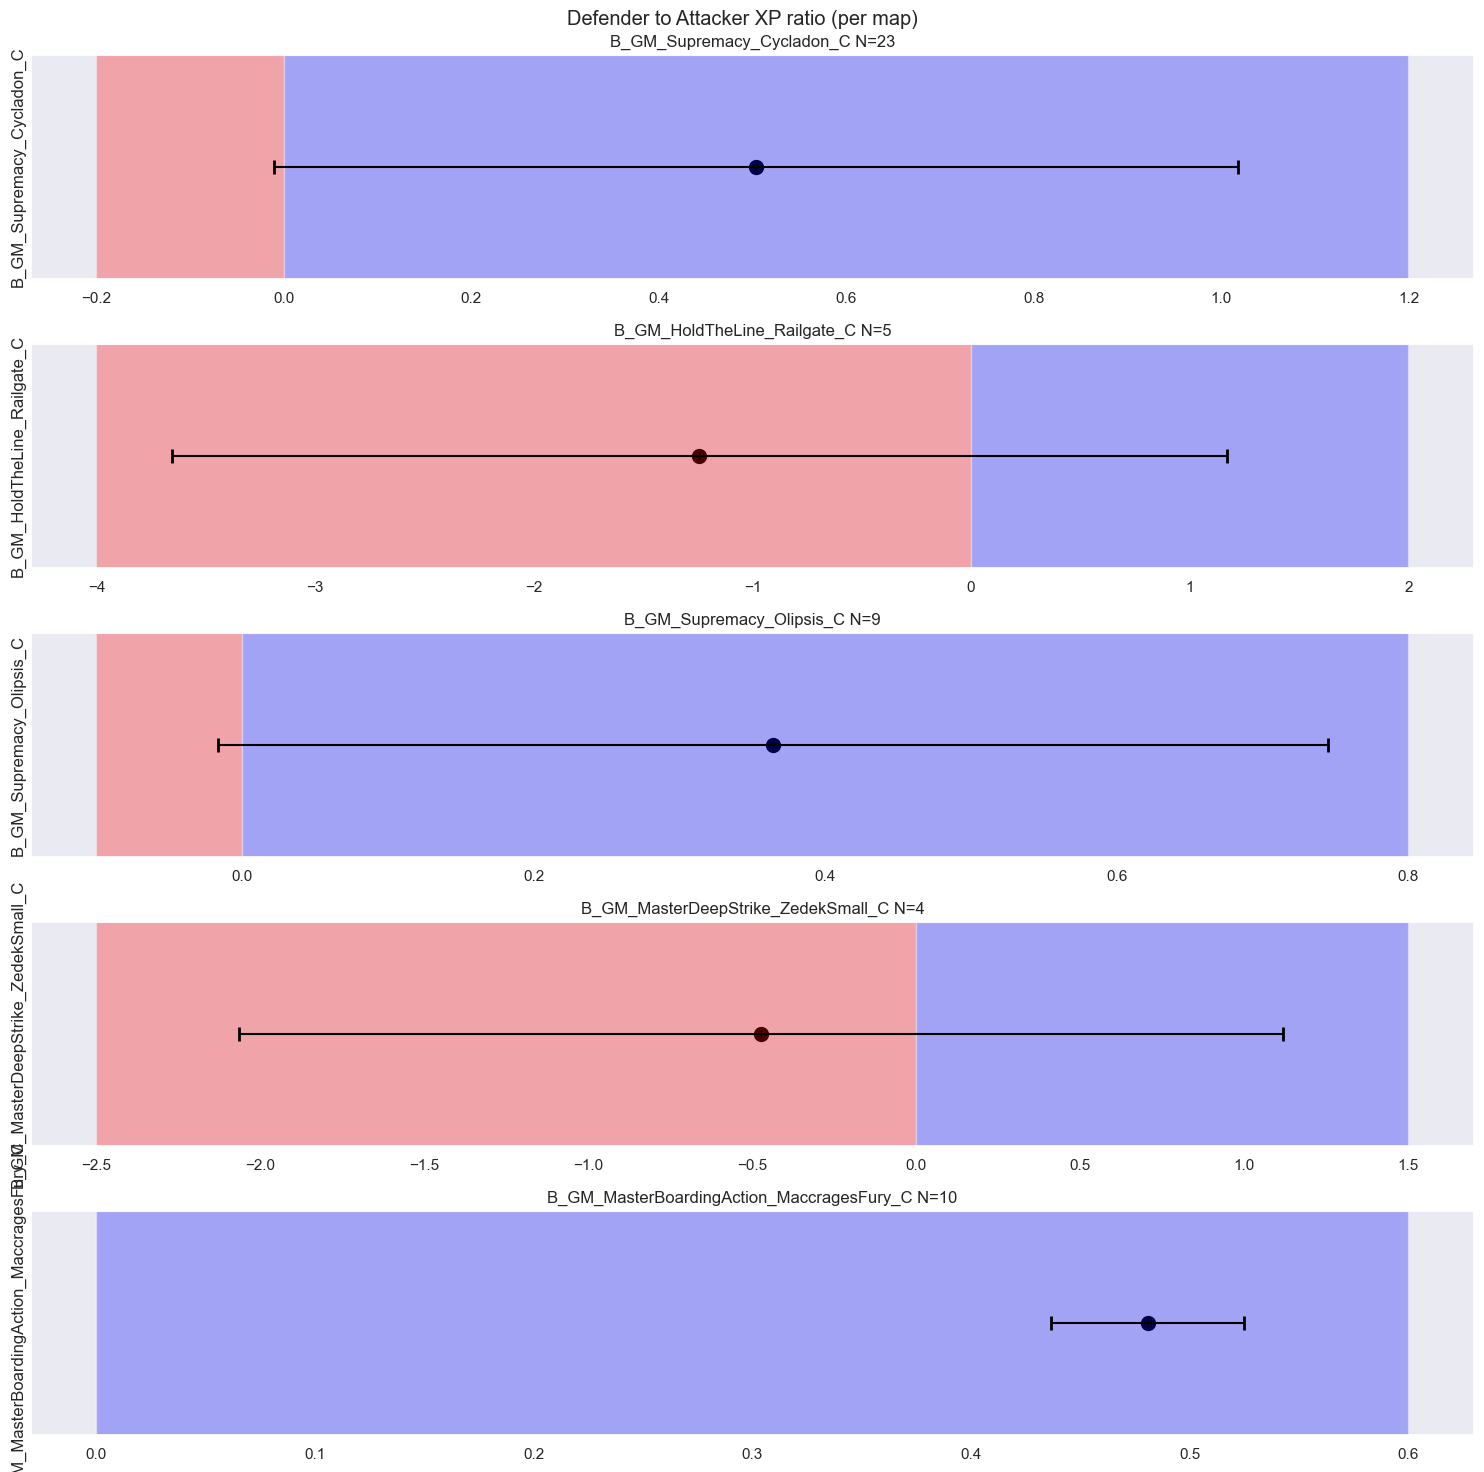

In [50]:
# Plot
if (graphs_by_matchup):
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 4, figsize=(len(keys)*4, 20))
    fig.suptitle("Defender to Attacker XP ratio (per map, per alliance)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        for j, subkey in enumerate(mission.keys()):
            df = pd.DataFrame(data=mission[subkey])
            grouped = df.groupby(0)[1]
            means = np.log2(grouped.mean())
            stds = abs(np.log2(grouped.std()))
            axes[i,j].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
            for k, (mean_val, std_val) in enumerate(zip(means, stds)):
                axes[i,j].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
            #axes[i,j].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
            axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
            axes[i,j].set_title(subkey)
            axes[i,j].axvspan(min(0.0, axes[i,j].get_xticks()[0]), min(0.0, axes[i,j].get_xticks()[-1]), facecolor='r', alpha=0.3)
            axes[i,j].axvspan(max(0.0, axes[i,j].get_xticks()[0]), max(0.0, axes[i,j].get_xticks()[-1]), facecolor='b', alpha=0.3)
            #axes[i,j].get_legend().remove()
        axes[i,0].set_ylabel(key)
    
    fig.tight_layout()

else:
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 1, figsize=(15, 15))
    fig.suptitle("Defender to Attacker XP ratio (per map)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        means = [np.log2(np.mean(mission))]
        stds = [abs(np.log2(np.std(mission)))]
        axes[i].scatter(means, 0, color='black', label='Mean', s=100, marker='o')
        for k, (mean_val, std_val) in enumerate(zip(means, stds)):
            axes[i].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        #axes[i].xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
        axes[i].set_title(key + " N=" + str(len(mission)))
        axes[i].axvspan(min(0.0, axes[i].get_xticks()[0]), min(0.0, axes[i].get_xticks()[-1]), facecolor='r', alpha=0.3)
        axes[i].axvspan(max(0.0, axes[i].get_xticks()[0]), max(0.0, axes[i].get_xticks()[-1]), facecolor='b', alpha=0.3)
        axes[i].set_yticks([])
        axes[i].set_ylabel(key)
    
    fig.tight_layout()

## 3) For every mission, get "(defenders' kills / defenders' spawns) / (same for attackers)", plot as mean +- std between matches (mission y, ratio x), vertical red line at 1

In [51]:
# Calculates the kills of a faction in a match
def get_side_kills(match, faction):
    sum = 0
    for e in match:
        if ((e["Type"] == "XP") and (e["action"] == "Enemy down") and (e["tf"] == faction)):
            sum += 1
    return sum

# Calculates the spawns of a faction in a match
def get_side_spawns(match, faction):
    sum = 0
    for e in match:
        if ((e["Type"] == "Spawn") and (e["tf"] == faction)):
            sum += 1
    return sum

In [52]:
missions = {}
if (graphs_by_matchup):
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate side kd
            resultA = match[-2]
            resultB = match[-3]
            killsA = get_side_kills(match, resultA["faction"])
            killsB = get_side_kills(match, resultB["faction"])
            spawnsA = get_side_spawns(match, resultA["faction"])
            spawnsB = get_side_spawns(match, resultB["faction"])
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = {}
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    if (resultA["result"] == "won"):
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    else:
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], ks])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], ks]]
                else:
                    if (resultA["result"] == "won"):
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    else:
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], ks])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], ks]]
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    if (resultA["result"] == "won"):
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    else:
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], ks])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], ks]]
                else:
                    if (resultA["result"] == "won"):
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    else:
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], ks])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], ks]]

else:
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner and teams
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate side kd
            resultA = match[-2]
            resultB = match[-3]
            killsA = get_side_kills(match, resultA["faction"])
            killsB = get_side_kills(match, resultB["faction"])
            spawnsA = get_side_spawns(match, resultA["faction"])
            spawnsB = get_side_spawns(match, resultB["faction"])
            
            if (not(end_entry["mission"] in missions.keys())):
                missions[end_entry["mission"]] = []
            
            if (t1[1] == "Defender"):
                if (winner[0] == t1[0]):
                    if (resultA["result"] == "won"):
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    else:
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    missions[end_entry["mission"]].append(ks)
                else:
                    if (resultA["result"] == "won"):
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    else:
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    missions[end_entry["mission"]].append(ks)
            # Either t2 is Defender or the map is symetric
            # Warning, a symmetric map will thus be randomly assigned a "Defender"
            else:
                if (winner[0] == t2[0]):
                    if (resultA["result"] == "won"):
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    else:
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    missions[end_entry["mission"]].append(ks)
                else:
                    if (resultA["result"] == "won"):
                        ks = (killsB/spawnsB)/(killsA/spawnsA)
                    else:
                        ks = (killsA/spawnsA)/(killsB/spawnsB)
                    missions[end_entry["mission"]].append(ks)

In [53]:
# missions

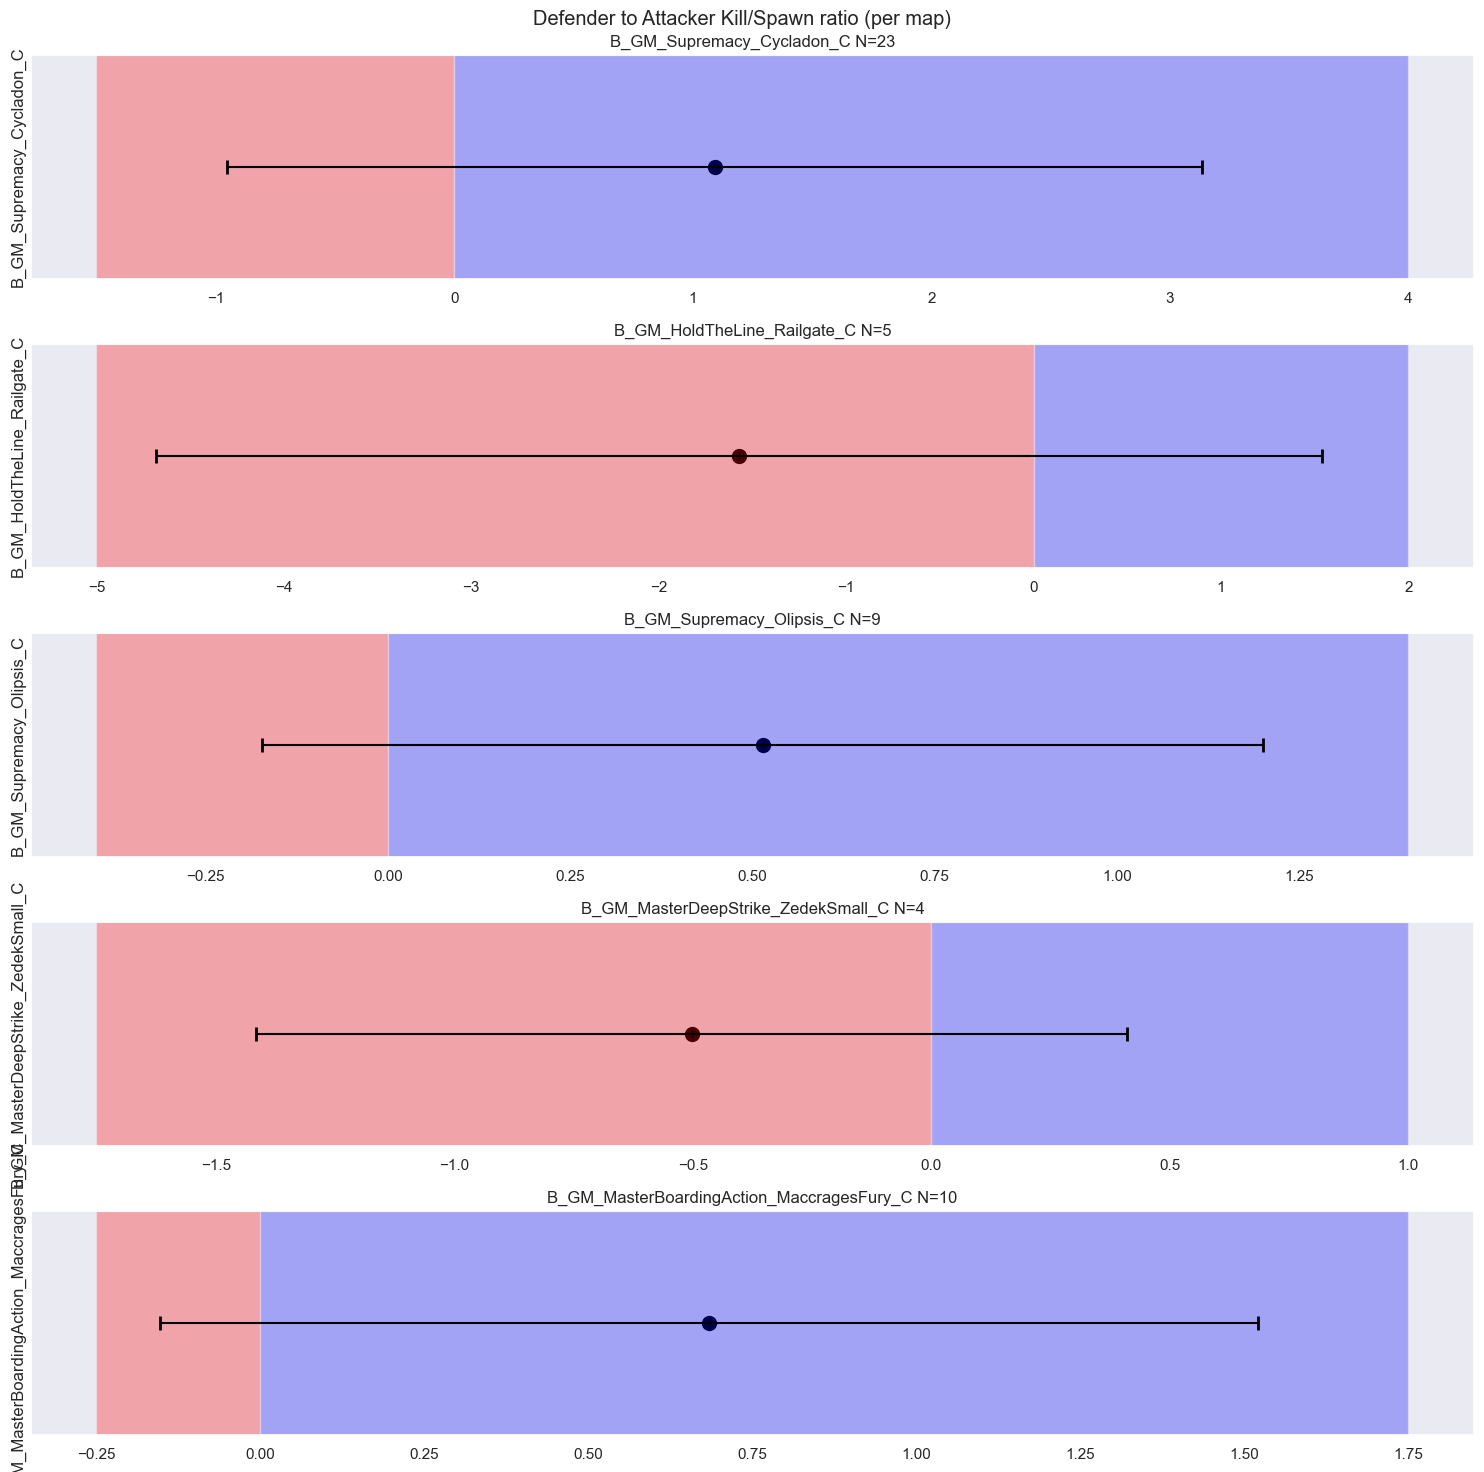

In [54]:
# Plot
if (graphs_by_matchup):
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 4, figsize=(len(keys)*4, 20))
    fig.suptitle("Defender to Attacker Kill/Spawn ratio (per map, per alliance)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        for j, subkey in enumerate(mission.keys()):
            df = pd.DataFrame(data=mission[subkey])
            grouped = df.groupby(0)[1]
            means = np.log2(grouped.mean())
            stds = abs(np.log2(grouped.std()))
            axes[i,j].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
            for k, (mean_val, std_val) in enumerate(zip(means, stds)):
                axes[i,j].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
            #axes[i,j].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
            axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
            axes[i,j].set_title(subkey)
            axes[i,j].axvspan(min(0.0, axes[i,j].get_xticks()[0]), min(0.0, axes[i,j].get_xticks()[-1]), facecolor='r', alpha=0.3)
            axes[i,j].axvspan(max(0.0, axes[i,j].get_xticks()[0]), max(0.0, axes[i,j].get_xticks()[-1]), facecolor='b', alpha=0.3)
            #axes[i,j].get_legend().remove()
        axes[i,0].set_ylabel(key)
    
    fig.tight_layout()

else:
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 1, figsize=(15, 15))
    fig.suptitle("Defender to Attacker Kill/Spawn ratio (per map)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        means = [np.log2(np.mean(mission))]
        stds = [abs(np.log2(np.std(mission)))]
        axes[i].scatter(means, 0, color='black', label='Mean', s=100, marker='o')
        for k, (mean_val, std_val) in enumerate(zip(means, stds)):
            axes[i].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        #axes[i].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
        axes[i].set_title(key + " N=" + str(len(mission)))
        axes[i].axvspan(min(0.0, axes[i].get_xticks()[0]), min(0.0, axes[i].get_xticks()[-1]), facecolor='r', alpha=0.3)
        axes[i].axvspan(max(0.0, axes[i].get_xticks()[0]), max(0.0, axes[i].get_xticks()[-1]), facecolor='b', alpha=0.3)
        axes[i].set_yticks([])
        axes[i].set_ylabel(key)
    
    fig.tight_layout()

## 4) For every mission, get match duration, plot as boxplots (mission y, duration x)

In [55]:
by_match_old_raw_data[15][-1]

{'map': 'CycladonComplex',
 'mission': 'B_GM_Supremacy_Cycladon_C',
 't1': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"ChaosSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 7098,\r\n\t"maxScore": 10000,\r\n\t"goal": "Attacker",\r\n\t"spawnsLimited": false\r\n}',
 't2': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 10000,\r\n\t"maxScore": 10000,\r\n\t"goal": "Defender",\r\n\t"spawnsLimited": true\r\n}',
 't3': '',
 't4': '',
 'pa': '',
 'ts': '',
 'winner': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 10000,\r\n\t"maxScore": 10000,\r\n\t"goal": "Defender",\r\n\t"spawnsLimited": true\r\n}',
 'duration': '1694197458.4',
 'minduration': '600.0',
 'maxduration': '1230.0',
 'Type': 'MatchEnd',
 'match_ts': '2023-09-08T18-24-22.324624'}

In [56]:
by_match_old_raw_data[15][0]

{'map': 'CycladonComplex',
 'mission': 'B_GM_Supremacy_Cycladon_C',
 'a1': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"ChaosSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 0,\r\n\t"maxScore": 10000,\r\n\t"goal": "Attacker",\r\n\t"spawnsLimited": false\r\n}',
 'a2': '{\r\n\t"alliance":\r\n\t{\r\n\t\t"factionNames": [\r\n\t\t\t"LoyalSpaceMarines"\r\n\t\t],\r\n\t\t"strength": 6\r\n\t},\r\n\t"score": 0,\r\n\t"maxScore": 10000,\r\n\t"goal": "Defender",\r\n\t"spawnsLimited": true\r\n}',
 'a3': '',
 'a4': '',
 'pa': '',
 'Type': 'MatchStart',
 'match_ts': '2023-09-08T18-24-22.324624'}

In [57]:
# missions
# 'duration': '1693923949.287'
# 1693929915.893
# 1693937725.18
# 1694037162.428
s = ("2023-09-17T18-43-18.354068").split('.')[0]
print(s)
a = datetime.strptime(s, "%Y-%m-%dT%H-%M-%S")
print(a)
b = datetime.utcfromtimestamp(1694977041.929)
print(b)
abs((a-b).total_seconds())

2023-09-17T18-43-18
2023-09-17 18:43:18
2023-09-17 18:57:21.929000


843.929

In [58]:
# Get missions played to the end
missions = {}
if (graphs_by_matchup):
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate match duration (in seconds)
            start_time = datetime.strptime(end_entry["match_ts"].split('.')[0], "%Y-%m-%dT%H-%M-%S")
            end_time = datetime.utcfromtimestamp(float(end_entry["duration"]))
            delta = abs((start_time-end_time).total_seconds())
            # If less than a minute, it should be wrong
            if (delta > 60):
            
                if (not(end_entry["mission"] in missions.keys())):
                    missions[end_entry["mission"]] = {}
                
                if (t1[1] == "Defender"):
                    if (t1[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t1[0]].append([t2[0], delta/60])
                    else:
                        missions[end_entry["mission"]][t1[0]] = [[t2[0], delta/60]]
                # Either t2 is Defender or the map is symetric
                # Warning, a symmetric map will thus be randomly assigned a "Defender"
                else:
                    if (t2[0] in missions[end_entry["mission"]].keys()):
                        missions[end_entry["mission"]][t2[0]].append([t1[0], delta/60])
                    else:
                        missions[end_entry["mission"]][t2[0]] = [[t1[0], delta/60]]

else:
    for match in by_match_old_raw_data:
        # Get the last entry of the match (closing entry aka result)
        end_entry = match[-1]
        # print(end_entry["mission"], end_entry["winner"])
    
        # Get winner
        winner = split_team_info(end_entry["winner"])
        # Was a winner found? (if not match closed before its end, ignore entry)
        if (winner[1] != ""):        
            t1 = split_team_info(end_entry["t1"])
            t2 = split_team_info(end_entry["t2"])
    
            # Calculate match duration (in seconds)
            start_time = datetime.strptime(end_entry["match_ts"].split('.')[0], "%Y-%m-%dT%H-%M-%S")
            end_time = datetime.utcfromtimestamp(float(end_entry["duration"]))
            delta = abs((start_time-end_time).total_seconds())
            # If less than a minute, it should be wrong
            if (delta > 60):
            
                if (not(end_entry["mission"] in missions.keys())):
                    missions[end_entry["mission"]] = []
                
                missions[end_entry["mission"]].append(delta/60)

In [59]:
# missions

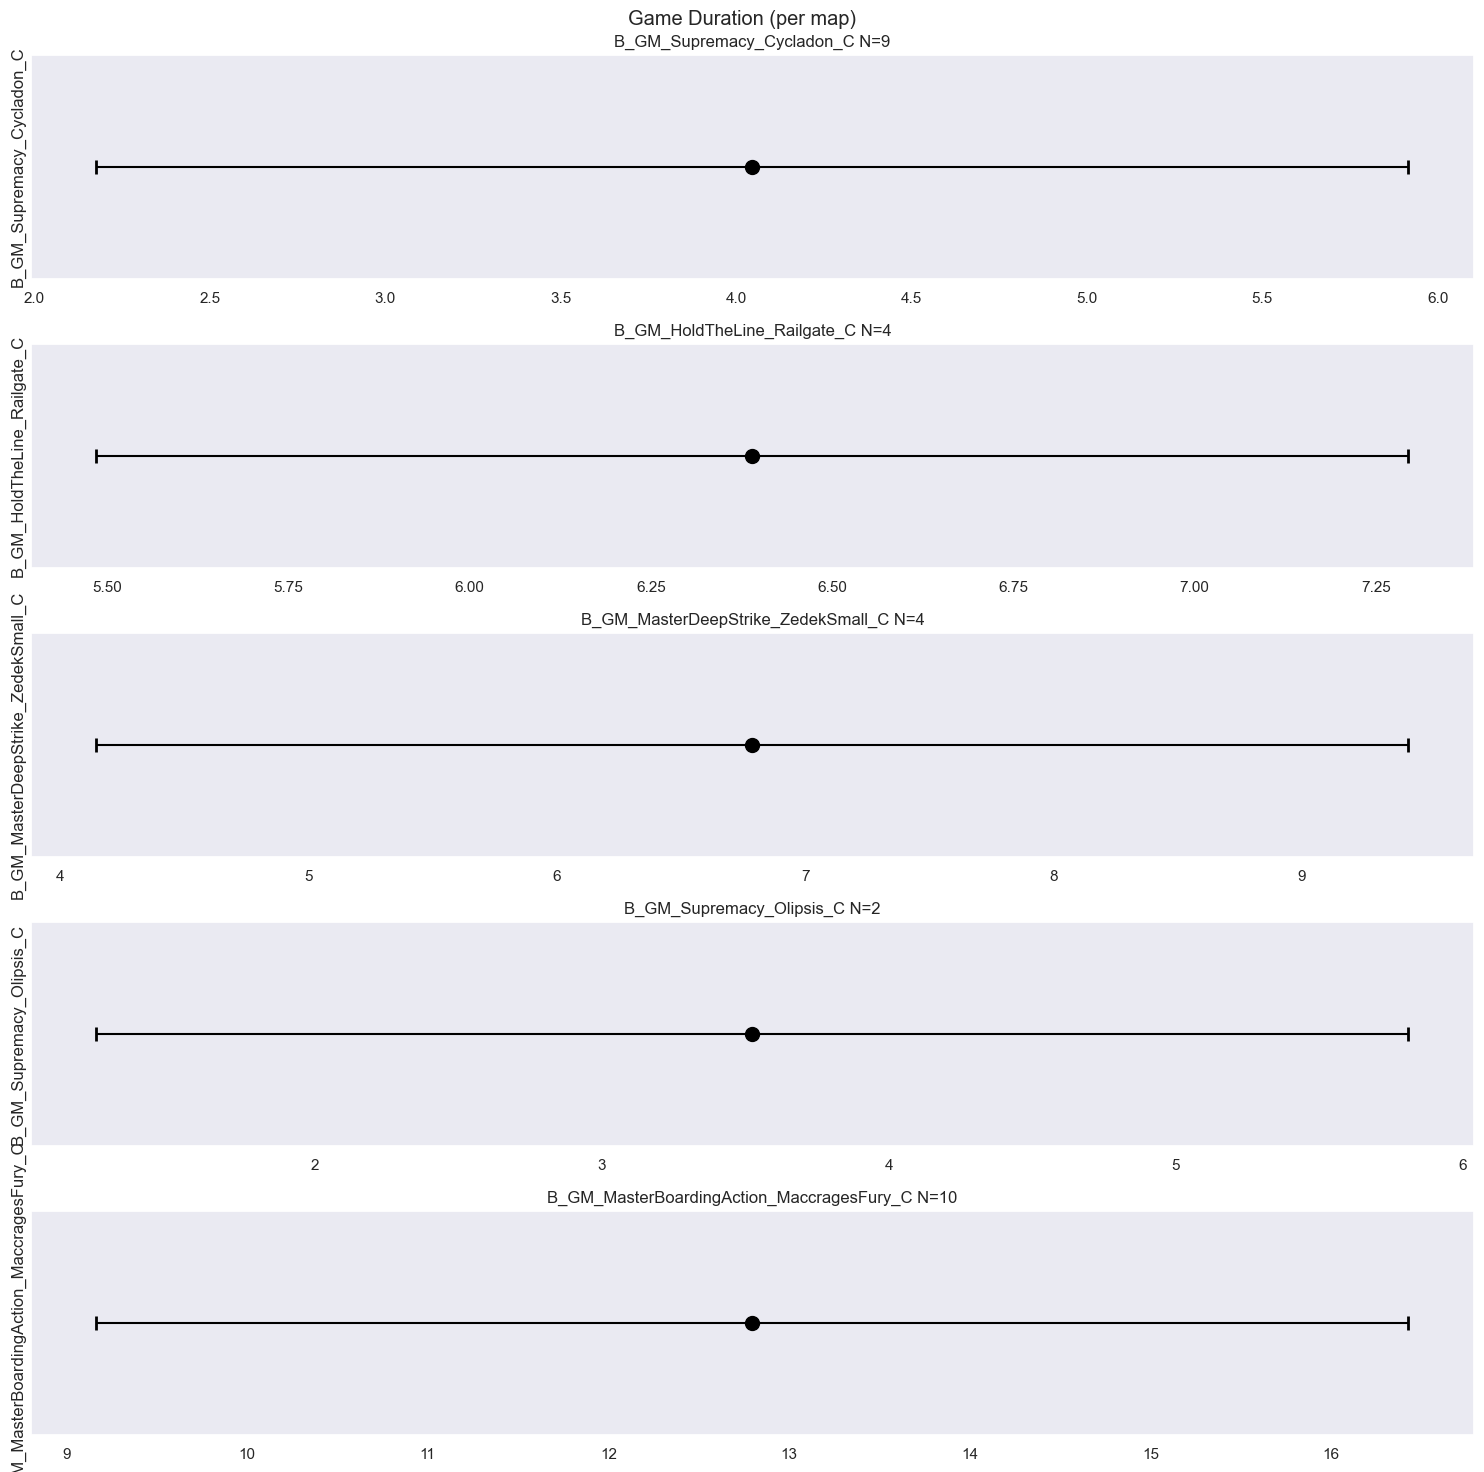

In [60]:
# Plot
if (graphs_by_matchup):
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 4, figsize=(len(keys)*4, 20))
    fig.suptitle("Game Duration (per map, per alliance)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        for j, subkey in enumerate(mission.keys()):
            df = pd.DataFrame(data=mission[subkey])
            grouped = df.groupby(0)[1]
            means = grouped.mean()
            stds = grouped.std()
            axes[i,j].scatter(means, means.index, color='black', label='Mean', s=100, marker='o')
            for k, (mean_val, std_val) in enumerate(zip(means, stds)):
                axes[i,j].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
            #axes[i,j].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
            axes[i,j].set_xlabel(key + " N=" + str(len(mission[subkey])))
            axes[i,j].set_title(subkey)
            #axes[i,j].get_legend().remove()
        axes[i,0].set_ylabel(key)
    
    fig.tight_layout()

else:
    keys = missions.keys()
    fig, axes = plt.subplots(len(keys), 1, figsize=(15, 15))
    fig.suptitle("Game Duration (per map)")
    
    for i, key in enumerate(missions.keys()):
        mission = missions[key]
        means = [np.mean(mission)]
        stds = [np.std(mission)]
        axes[i].scatter(means, 0, color='black', label='Mean', s=100, marker='o')
        for k, (mean_val, std_val) in enumerate(zip(means, stds)):
            axes[i].errorbar(mean_val, k, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        #axes[i].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0])
        axes[i].set_title(key + " N=" + str(len(mission)))
        axes[i].set_yticks([])
        axes[i].set_ylabel(key)
    
    fig.tight_layout()